In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
df=pd.read_excel(r'CDCW (2).xlsx',parse_dates=['Month'], index_col=0)

In [17]:
df.head()

,Counsellor Name,Course Name,Fees Total,Fees Received,Fees Pending
Month,,,,,
2020-04-01,SK,CADM,5000.0,5000.0,0
2020-04-01,SK,CDCW,7500.0,7500.0,0
2020-04-01,SK,CDCW,9500.0,9500.0,0
2020-04-01,SK,CDCW,9500.0,9500.0,0
2020-04-01,SK,CDCW,9000.0,9000.0,0


In [20]:
df.drop(df.columns[[0, 1, 2, 3, 5 axis=1]],inplace=True)

SyntaxError: invalid syntax (<ipython-input-20-4fa35859fee0>, line 1)

In [21]:
df.drop(columns=["Counsellor Name","Course Name","Fees Received","Fees Pending"],inplace=True)

In [22]:
df.rename(columns={'Fees Total':'sales'}, inplace=True)
df

,sales
Month,
2020-04-01,5000.0
2020-04-01,7500.0
2020-04-01,9500.0
2020-04-01,9500.0
2020-04-01,9000.0
...,...
2021-07-01,12000.0
2021-07-01,15000.0
2021-07-01,9500.0


In [23]:
df.rename(columns={'Fees Total':'sales'}, inplace=True)
df

,sales
Month,
2020-04-01,5000.0
2020-04-01,7500.0
2020-04-01,9500.0
2020-04-01,9500.0
2020-04-01,9000.0
...,...
2021-07-01,12000.0
2021-07-01,15000.0
2021-07-01,9500.0


<AxesSubplot:xlabel='Month'>

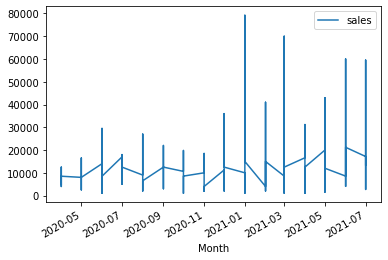

In [24]:
df.plot()

# Resample

In [25]:
ts=df['sales'].resample('MS').sum()

In [26]:
ts.head()

Month
2020-04-01     187000.0
2020-05-01     884935.0
2020-06-01    1090372.2
2020-07-01    1239974.0
2020-08-01    1447288.0
Freq: MS, Name: sales, dtype: float64

<AxesSubplot:xlabel='Month'>

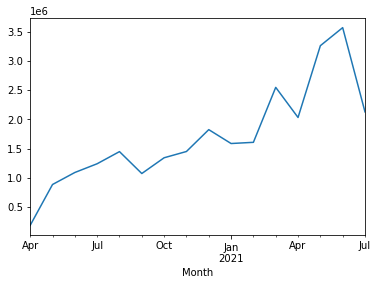

In [27]:
ts.plot()

# check for stationary

In [29]:
import statsmodels.api as sm

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
adftest=adfuller(ts)

In [32]:
print('p value of adfuller test is:', adftest[1])

p value of adfuller test is: 0.9986854642036265


# Making series stationary

In [33]:
df['adj_sqrt'] = np.sqrt(df['sales'])
df['sales_sqrt_Difference'] = df['adj_sqrt'] - df['adj_sqrt'].shift(1)
adftest=adfuller(df['sales_sqrt_Difference'].dropna())
print('p value of adfuller test is:', adftest[1])

p value of adfuller test is: 8.895104219123753e-30


In [34]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

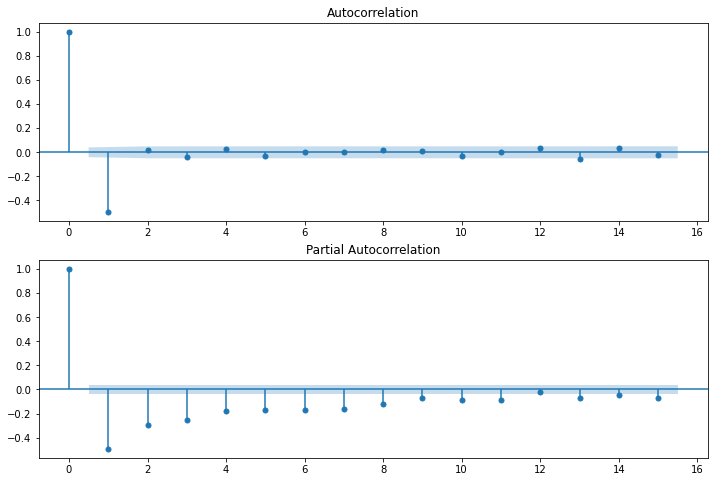

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['sales_sqrt_Difference'].dropna(),lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['sales_sqrt_Difference'].dropna(),lags=15,ax=ax2)

# Train Test Split

In [36]:
from sklearn.metrics import mean_squared_error

In [37]:
len(ts)

16

In [38]:
train=ts[:12]
test=ts[12:]

In [39]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# finding p,d,q for loop

In [40]:
import itertools

In [41]:
p=range(0,5)
d=range(0,2)
q=range(0,10)

In [42]:
pdq_combinations=list(itertools.product(p,d,q))

In [43]:
len(pdq_combinations)

100

In [44]:
rmse=[]
order1=[]

In [45]:
for pdq in pdq_combinations:
    try:
        model=ARIMA(train,order=pdq).fit()
        pred=model.predict(start=len(train),end=(len(ts)-1))
        error=np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)
    
    except:
        continue

In [46]:
results=pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])
results.to_csv(r'ARIMA predictions.csv',index=True)
results

,RMSE
"(0, 0, 0)",1.545754e+06
"(0, 0, 1)",1.508493e+06
"(0, 0, 2)",1.481601e+06
"(0, 0, 4)",1.217906e+06
"(0, 0, 5)",1.084514e+06
...,...
"(4, 1, 5)",7.734862e+05
"(4, 1, 6)",8.995513e+05
"(4, 1, 7)",7.325143e+05
"(4, 1, 8)",9.680802e+05


In [47]:
results['RMSE'].idxmin() #required p,d,q

(4, 1, 2)

# Predict test data

In [48]:
model=ARIMA(train,order=(2,1,7)).fit()

# model evaluation

In [49]:
pred=model.predict(start=len(train),end=(len(ts)-1))

In [50]:
pred.head()

2021-04-01    2.852869e+06
2021-05-01    2.985418e+06
2021-06-01    3.095167e+06
2021-07-01    3.596445e+06
Freq: MS, Name: predicted_mean, dtype: float64

In [51]:
error

803568.493888702

In [52]:
test.mean(), np.sqrt(test.var())

(2745970.0, 781485.2077614777)

<AxesSubplot:xlabel='Month'>

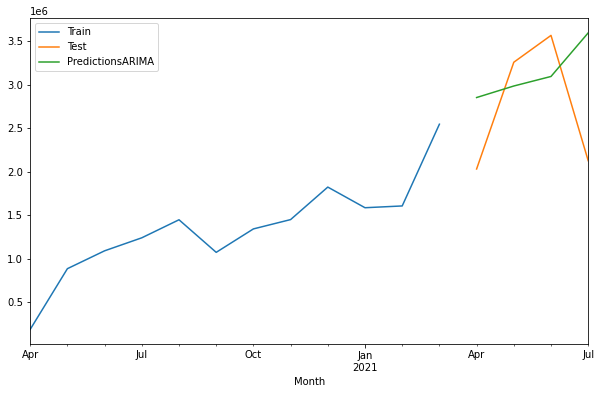

In [53]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend=True, label='Test')
pred.plot(legend=True, label='PredictionsARIMA')

In [54]:
final_model=ARIMA(ts,order=(2,1,7)).fit()

In [55]:
prediction=final_model.predict(len(ts),len(ts)+6)

<AxesSubplot:xlabel='Month'>

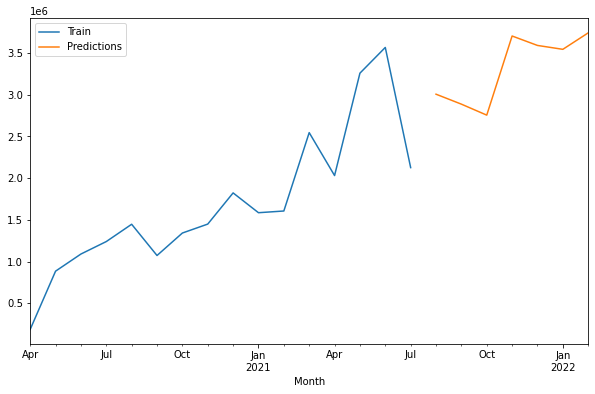

In [56]:
ts.plot(legend=True, label='Train', figsize=(10,6))
prediction.plot(legend=True, label='Predictions') 

In [57]:
prediction

2021-08-01    3.006728e+06
2021-09-01    2.887384e+06
2021-10-01    2.755731e+06
2021-11-01    3.704443e+06
2021-12-01    3.591304e+06
2022-01-01    3.544758e+06
2022-02-01    3.742064e+06
Freq: MS, Name: predicted_mean, dtype: float64